In [1]:
import torch
from torch import nn, optim
import torchvision
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
torch.__version__

'1.5.1'

In [3]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.conv = nn.Sequential(
            # 32*28*28*3
            nn.Conv2d(3, 32, 3, 1), # in_channels, out_channels, kernel_size, stride, padding
            nn.MaxPool2d(2, 2), # kernel_size, stride
            nn.ReLU(),            
            # 减小卷积窗口，使用填充为2来使得输入与输出的高和宽一致，且增加输出通道数
            # 64*14*14
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
        # 连续3个卷积层，且使用更小的卷积窗口。除了最后的卷积层外，进一步 增加了输出通道数。
        # 前两个卷积层后不使用池化层来减小输入的⾼和宽 
            # 128*7*7
            nn.Conv2d(64, 128, 3, 1, 1), 
            # 256*7*7
            nn.Conv2d(128, 256, 3, 1, 1), 
            # 256*7*7
            nn.Conv2d(256, 256, 3, 1, 1), 
            # 256*3*3
            nn.MaxPool2d(2, 2),
            nn.ReLU()
        )
        # 这里全连接层的输出个数 ALexNet中的数倍。使用dropout来缓解过拟合。
        self.fc = nn.Sequential(
        # 输出层，10分类
            nn.Linear(256*3*3, 1024),
            nn.Linear(1024, 512),
            nn.Linear(512, 10),
        )
    def forward(self, img):
        feature = self.conv(img)
        output = self.fc(feature.view(img.shape[0], -1))
        return output

In [4]:
# cifar10数据集下载
train_data = datasets.CIFAR10(root='./cifar10/',
                         train=True,                         # 这里是训练集
                         # 数据变换(0, 255) -> (0, 1)
                         transform=transforms.ToTensor(),    # 将PIL Image或者numpy.ndarray转化为torch.FloatTensor，shape为(C,H,W)，并且归一化到[0.0, 1.0]
#                          download=True
                           )

test_data = datasets.CIFAR10(root='./cifar10/',
                        train=False,                         # 测试集
                        transform=transforms.ToTensor(),
#                         download=True
                          )




In [5]:
print('训练集大小：', train_data.data.shape)   # 查看训练集数据大小，60000张28*28的图片 (60000, 28, 28)
print('训练集标签个数：', len(train_data.targets))

训练集大小： (50000, 32, 32, 3)
训练集标签个数： 50000


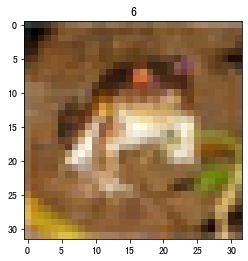

In [6]:
# plot其中一张手写数字图片
# plt.imshow(train_data[0][0].numpy(), cmap='gray') # plot 训练集第一张图片
plt.imshow(train_data[0][0].numpy().transpose(1,2,0)) # plot 训练集第一张图片
plt.title('%i' % train_data[0][1])              # 图片名称，显示真实标签，%i %d十进制整数，有区别，深入请查阅资料
plt.show() 

In [10]:
# 使用DataLoader进行分批
BATCH_SIZE = 64
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=True)

In [8]:
# AlexNet Model
model = AlexNet()
#损失函数:这里用交叉熵
criterion = nn.CrossEntropyLoss()
#优化器 这里用SGD
optimizer = optim.Adam(model.parameters(), lr=1e-5)

#device : GPU or CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

AlexNet(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=2304, out_features=1024, bias=True)
    (1): Linear(in_features=1024, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [73]:
# 训练
EPOCH = 100
for epoch in range(EPOCH):
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # 前向传播
        outputs = model(inputs)
        # 计算损失函数
        loss = criterion(outputs, labels)
        # 清空上一轮梯度
        optimizer.zero_grad()
        # 反向传播
        loss.backward()
        # 参数更新
        optimizer.step()

    print('epoch{} loss:{:.4f}'.format(epoch+1, loss.item()))

print("Finished Traning")


#保存训练模型
torch.save(model, 'cifar10_alexnet.pt')
model = torch.load('cifar10_alexnet.pt')

epoch1 loss:2.0492
epoch2 loss:1.6523
epoch3 loss:1.7241
epoch4 loss:1.3997
epoch5 loss:1.9471
epoch6 loss:1.7188
epoch7 loss:1.3282
epoch8 loss:1.1216
epoch9 loss:1.5981
epoch10 loss:1.2750
epoch11 loss:1.4497
epoch12 loss:0.9929
epoch13 loss:1.4073
epoch14 loss:1.2715
epoch15 loss:1.6224
epoch16 loss:1.7254
epoch17 loss:0.9124
epoch18 loss:0.8790
epoch19 loss:0.7760
epoch20 loss:0.7861
epoch21 loss:1.2125
epoch22 loss:0.9688
epoch23 loss:1.0111
epoch24 loss:1.0038
epoch25 loss:1.4109
epoch26 loss:0.9728
epoch27 loss:0.9961
epoch28 loss:0.9350
epoch29 loss:1.2552
epoch30 loss:0.8937
epoch31 loss:1.5394
epoch32 loss:0.9269
epoch33 loss:1.4092
epoch34 loss:1.2092
epoch35 loss:0.8571
epoch36 loss:0.8551
epoch37 loss:0.8482
epoch38 loss:1.3419
epoch39 loss:0.7439
epoch40 loss:0.8554
epoch41 loss:0.6850
epoch42 loss:0.9617
epoch43 loss:0.8504
epoch44 loss:1.0064
epoch45 loss:1.2041
epoch46 loss:0.9591
epoch47 loss:0.8267
epoch48 loss:0.8248
epoch49 loss:0.8898
epoch51 loss:1.2123
epoch52 l

In [11]:
# 测试
model.eval()
correct = 0
total = 0

for data in test_loader:
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    # 前向传播
    out = model(images)
    _, predicted = torch.max(out.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

#输出识别准确率
print('10000测试图像 准确率:{:.4f}%'.format(100 * correct / total)) 

10000测试图像 准确率:71.4800%
